<a href="https://colab.research.google.com/github/ayan59dutta/election_parameters/blob/master/election_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data from Github repo

In [1]:
!git clone https://github.com/ayan59dutta/election_parameters.git

Cloning into 'election_parameters'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 34), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (64/64), done.


# Load data from file into dataframes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
colmn_list = ['Candidate', 'Constituency', 'Criminal Case', 'Education', 'Total Assets', 'Liabilities']

def convert(x):
    return int(x.split()[1].replace(',', '').replace('~', ''))

df1_cand_details = pd.read_excel('election_parameters/data/MyNeta_UP_Assembly_ELections_2017.xlsx',
                          usecols=colmn_list,
                          converters={'Candidate': lambda x:x.upper(),
                                     'Total Assets': convert,
                                     'Liabilities': convert})

df1_cand_details['Net Assets'] = df1_cand_details['Total Assets'] - df1_cand_details['Liabilities']
df1_cand_details = df1_cand_details.drop(columns=['Total Assets', 'Liabilities'])
df1_cand_details.rename(columns={'Candidate': 'CAND_NAME', 
                                 'Constituency': 'AC_NAME', 
                                 'Criminal Case': 'C_CASE',
                                 'Education': 'EDU', 
                                 'Net Assets': 'NET_ASSETS'}, 
                        inplace=True)
df1_cand_details

,CAND_NAME,AC_NAME,C_CASE,EDU,NET_ASSETS
0,A HASIV,ARYA NAGAR,0,12th Pass,33578492
1,A WAHID,GAINSARI,0,10th Pass,75106
2,AAN SHIKHAR SHRIVASTAVA,GOSHAINGANJ,0,Graduate,41000
3,AAPTAB URF AFTAB,MUBARAKPUR,0,Illiterate,20000
4,AASHI GAUR,KHATAULI,0,Literate,3468543
...,...,...,...,...,...
4822,ZAKIR ALI RANA,MUZAFFAR NAGAR,1,12th Pass,46819551
4823,ZAMEER ULLAH KHAN,KOIL,3,8th Pass,14521200
4824,ZEBA RIZWAN,TULSIPUR,0,Post Graduate,357000
4825,ZIYAUDDIN RIZVI,SIKANDERPUR,0,Graduate,22463063


In [52]:
colmn_list = ['ST_CODE', 'AC_NAME', 'AC_TYPE', 'CAND_NAME', 'CAND_SEX', 
              'CAND_CATEGORY', 'CAND_AGE', 'TOTVOTPOLL', 'POSITION']

df_ae12 = pd.read_excel('election_parameters/data/AE2012_8913.xls',
                        usecols=colmn_list,
                        header=1,
                        converters={'AC_NAME': lambda x: x.upper()})

df_ae12 = df_ae12[df_ae12.ST_CODE == 'S24']

df_ae12 = df_ae12.drop('ST_CODE', axis=1).reset_index().drop('index', axis=1)

df_ae12

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTVOTPOLL,POSITION
0,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,50,70274,1
1,BEHAT,GEN,NARESH,M,GEN,47,69760,2
2,BEHAT,GEN,UMAR ALI KHAN,M,GEN,34,47366,3
3,BEHAT,GEN,AJAY CHAUHAN,M,GEN,29,23623,4
4,BEHAT,GEN,DHARAM SINGH,M,SC,39,2251,5
...,...,...,...,...,...,...,...,...
7026,DUDDHI,SC,RAJA RAM,M,SC,46,2876,7
7027,DUDDHI,SC,RADHESHYAM GOND,M,SC,50,1813,8
7028,DUDDHI,SC,GAMBHIRA PRASAD,M,SC,43,1690,9
7029,DUDDHI,SC,BIHARI LAL,M,SC,50,1439,10


In [53]:
la_2017 = pd.read_excel('election_parameters/data/LA_2017.xls', 
                        usecols = [1, 6, 7, 8, 9,10, 11, 13, 14], 
                        converters={'AC_NAME': lambda x:x.upper(),
                                    'CAND_NAME': lambda x: x.upper()})
la_2017  = la_2017.drop(la_2017[la_2017.ST_NAME != 'Uttar Pradesh'].index)
la_2017 = la_2017.drop('ST_NAME', axis = 1).reset_index().drop('index', axis=1)
la_2017

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4
4,BEHAT,GEN,NONE OF THE ABOVE,NaN,NaN,NaN,1576,5
...,...,...,...,...,...,...,...,...
5302,DUDDHI,ST,PRATOSH KUMAR,M,ST,55.0,4699,5
5303,DUDDHI,ST,SHIVKUMAR KHARWAR,M,ST,44.0,3312,6
5304,DUDDHI,ST,VIGAN RAM,M,ST,49.0,2431,7
5305,DUDDHI,ST,AMAR SINGH,M,ST,35.0,2147,8


## Anti-Incumbency Check

In [0]:
winners_ae12 = df_ae12[df_ae12['POSITION'] == 1]
winners_la17 = la_2017[la_2017['POSITION'] == 1]
print(winners_ae12)
print(winners_la17)

#winners_ae12 

# no_of_winners_12and17 = 0
# no_of_winners_12not17 = 0
# no_of_winners_12abs17 = 0

# for index, row in winners_ae12.iterrows():
#   #print(row.CAND_NAME)
#   if row.CAND_NAME in la_2017['CAND_NAME']:
#     print(row.CAND_NAME)
#     break
# else:
#   print('Over')
  
set1 = set(winners_ae12.CAND_NAME)
# print(set1)
set2 = set(winners_ae12.CAND_NAME)
# set2
set12 = set1.intersection(set2)
len(set12)

               AC_NAME AC_TYPE  ... TOTVOTPOLL POSITION
0                BEHAT     GEN  ...      70274        1
13               NAKUR     GEN  ...      89187        1
29    SAHARANPUR NAGAR     GEN  ...      85170        1
47        SAHARANPUR       GEN  ...      80670        1
62             DEOBAND     GEN  ...      66682        1
...                ...     ...  ...        ...      ...
6923           MARIHAN     GEN  ...      63492        1
6946          GHORAWAL     GEN  ...      87708        1
6963       ROBERTSGANJ     GEN  ...      47139        1
6990              OBRA     GEN  ...      31513        1
7020           DUDDHI       SC  ...      42028        1

[403 rows x 8 columns]
               AC_NAME AC_TYPE  ... TOTALVALIDVOTESPOLLED POSITION
0                BEHAT     GEN  ...                 97035        1
14               NAKUR     GEN  ...                 94375        1
26    SAHARANPUR NAGAR     GEN  ...                127210        1
41        SAHARANPUR       GEN  ... 

400

In [0]:
la_2017.CAND_NAME

0                   NARESH SAINI
1            MAHAVEER SINGH RANA
2                    MOHD. IQBAL
3       RANA ADITYA PRATAP SINGH
4              NONE OF THE ABOVE
                  ...           
5302               PRATOSH KUMAR
5303           SHIVKUMAR KHARWAR
5304                   VIGAN RAM
5305                  AMAR SINGH
5306                     ASHARFI
Name: CAND_NAME, Length: 5307, dtype: object

## Join the dataframes

In [54]:
la17_df = la_2017.merge(right=df1_cand_details, 
                        how='left',
                        on=['AC_NAME', 'CAND_NAME'])
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
4,BEHAT,GEN,NONE OF THE ABOVE,NaN,NaN,NaN,1576,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5314,DUDDHI,ST,PRATOSH KUMAR,M,ST,55.0,4699,5,NaN,NaN,NaN
5315,DUDDHI,ST,SHIVKUMAR KHARWAR,M,ST,44.0,3312,6,NaN,NaN,NaN
5316,DUDDHI,ST,VIGAN RAM,M,ST,49.0,2431,7,NaN,NaN,NaN
5317,DUDDHI,ST,AMAR SINGH,M,ST,35.0,2147,8,NaN,NaN,NaN


### Dropping NOTA

In [55]:
la17_df = la17_df[la17_df.CAND_NAME != 'NONE OF THE ABOVE']
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
5,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6,0.0,10th Pass,682859.0
...,...,...,...,...,...,...,...,...,...,...,...
5314,DUDDHI,ST,PRATOSH KUMAR,M,ST,55.0,4699,5,NaN,NaN,NaN
5315,DUDDHI,ST,SHIVKUMAR KHARWAR,M,ST,44.0,3312,6,NaN,NaN,NaN
5316,DUDDHI,ST,VIGAN RAM,M,ST,49.0,2431,7,NaN,NaN,NaN
5317,DUDDHI,ST,AMAR SINGH,M,ST,35.0,2147,8,NaN,NaN,NaN


### Dropping NaN values

In [56]:
la17_df = la17_df.dropna().reset_index(drop=True)
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6,0.0,10th Pass,682859.0
...,...,...,...,...,...,...,...,...,...,...,...
2950,ROBERTSGANJ,GEN,BINDU KUMAR,M,GEN,27.0,686,15,0.0,8th Pass,443000.0
2951,ROBERTSGANJ,GEN,SANTOSH SINGH PATEL,M,GEN,29.0,654,16,1.0,12th Pass,952000.0
2952,ROBERTSGANJ,GEN,CHANDRA KUMAR,M,GEN,45.0,601,17,0.0,8th Pass,12156000.0
2953,ROBERTSGANJ,GEN,M AYUB KHAN,M,GEN,72.0,598,18,0.0,10th Pass,4401000.0


### Change datatypes of columns from float to int

In [57]:
la17_df = la17_df.astype({"CAND_AGE": int, "C_CASE" : int, "NET_ASSETS": int})
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53,97035,1,0,Post Graduate,10382291
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55,71449,2,0,Graduate Professional,52678213
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52,71019,3,0,Literate,129888857
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49,4187,4,0,12th Pass,65633483
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37,1255,6,0,10th Pass,682859
...,...,...,...,...,...,...,...,...,...,...,...
2950,ROBERTSGANJ,GEN,BINDU KUMAR,M,GEN,27,686,15,0,8th Pass,443000
2951,ROBERTSGANJ,GEN,SANTOSH SINGH PATEL,M,GEN,29,654,16,1,12th Pass,952000
2952,ROBERTSGANJ,GEN,CHANDRA KUMAR,M,GEN,45,601,17,0,8th Pass,12156000
2953,ROBERTSGANJ,GEN,M AYUB KHAN,M,GEN,72,598,18,0,10th Pass,4401000


## Set Targets

In [58]:
la17_df.loc[la17_df['POSITION'] == 1, 'POSITION'] = 1
la17_df.loc[la17_df['POSITION'] > 1, 'POSITION'] = 0
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53,97035,1,0,Post Graduate,10382291
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55,71449,0,0,Graduate Professional,52678213
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52,71019,0,0,Literate,129888857
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49,4187,0,0,12th Pass,65633483
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37,1255,0,0,10th Pass,682859
...,...,...,...,...,...,...,...,...,...,...,...
2950,ROBERTSGANJ,GEN,BINDU KUMAR,M,GEN,27,686,0,0,8th Pass,443000
2951,ROBERTSGANJ,GEN,SANTOSH SINGH PATEL,M,GEN,29,654,0,1,12th Pass,952000
2952,ROBERTSGANJ,GEN,CHANDRA KUMAR,M,GEN,45,601,0,0,8th Pass,12156000
2953,ROBERTSGANJ,GEN,M AYUB KHAN,M,GEN,72,598,0,0,10th Pass,4401000


## Training and Test set

In [0]:
features_names = ['CAND_NAME', 'CAND_SEX', 'CAND_CATEGORY', 'CAND_AGE', 'C_CASE', 'EDU', 'NET_ASSETS']
X = la17_df[features_names]
y = la17_df['POSITION']
X = pd.get_dummies(X)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## K-Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder

In [63]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[547   6]
 [ 37   1]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       553
           1       0.14      0.03      0.04        38

    accuracy                           0.93       591
   macro avg       0.54      0.51      0.50       591
weighted avg       0.89      0.93      0.90       591



### Comparing Error Rate with the K Value

In [0]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

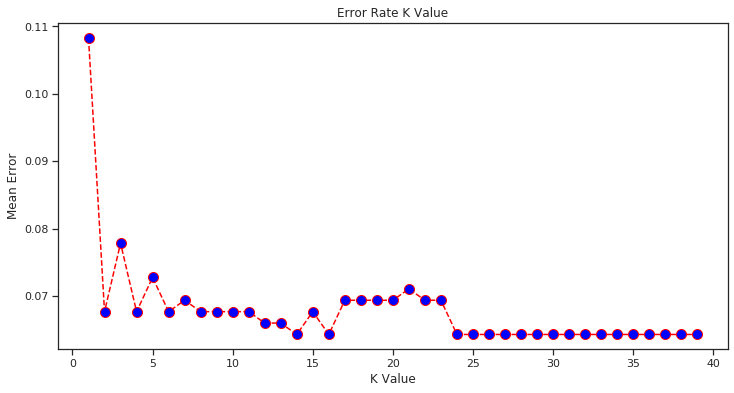

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [68]:
logreg_model = LogisticRegression()
result = logreg_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
result.score(X_test, y_test)

0.9323181049069373

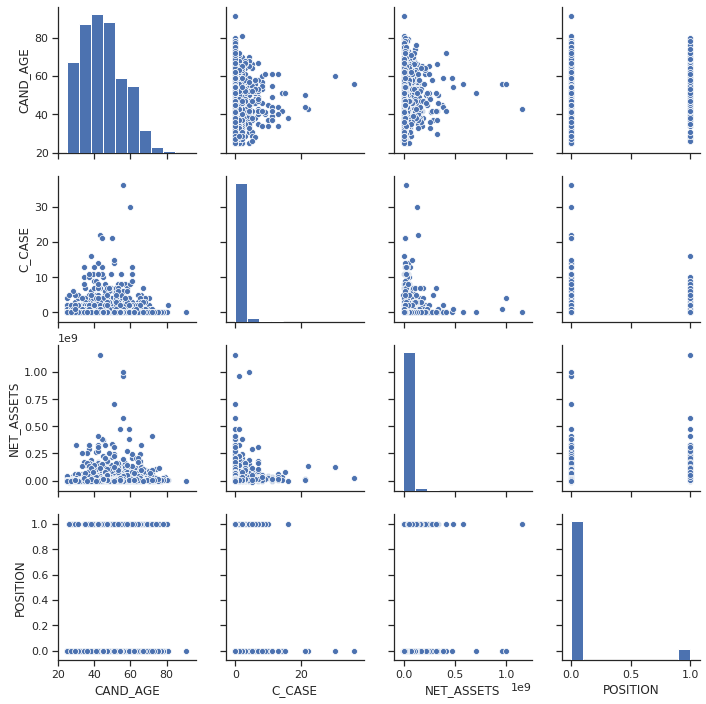

In [70]:
sns.pairplot(data=la17_df[['CAND_SEX', 'CAND_CATEGORY', 'CAND_AGE', 'C_CASE', 'EDU', 'NET_ASSETS', 'POSITION']])

In [0]:
sns.set(style="ticks", color_codes=True)

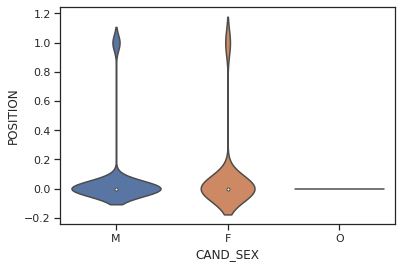

In [72]:
sns.violinplot(x='CAND_SEX', y='POSITION', data=la17_df)

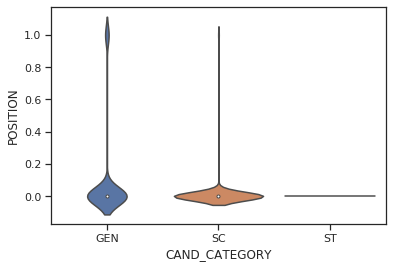

In [73]:
sns.violinplot(x='CAND_CATEGORY', y='POSITION', data=la17_df)